In [3]:
# ✅ Install and import necessary libraries
!pip install wandb -q

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import wandb


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import pandas as pd

# 1. Prepare Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

# 2. Define model with variable layers
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(SimpleNN, self).__init__()
        layers = []
        in_size = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(in_size, h))
            layers.append(nn.ReLU())
            in_size = h
        layers.append(nn.Linear(in_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# 3. Training function
def train_model(learning_rate, batch_size, num_layers, hidden_size, epochs=5):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleNN(28*28, [hidden_size]*num_layers, 10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            images = images.view(images.size(0), -1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()

        train_acc = correct / len(train_loader.dataset)

    # Validation accuracy
    model.eval()
    correct_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            images = images.view(images.size(0), -1)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct_val += (preds == labels).sum().item()

    val_acc = correct_val / len(val_loader.dataset)
    return train_acc, val_acc

# 4. Run experiments
configs = [
    {'learning_rate': 0.001, 'batch_size': 32, 'num_layers': 1, 'hidden_size': 64},
    {'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 1, 'hidden_size': 64},
    {'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 2, 'hidden_size': 128},
    {'learning_rate': 0.0005, 'batch_size': 32, 'num_layers': 2, 'hidden_size': 64},
]

results = []

for i, cfg in enumerate(configs):
    print(f"Running config {i+1}/{len(configs)}: {cfg}")
    train_acc, val_acc = train_model(**cfg, epochs=5)
    results.append({**cfg, 'train_accuracy': train_acc, 'val_accuracy': val_acc})

# 5. Show results
df = pd.DataFrame(results)
print("\nSummary of results:")
print(df)


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.90MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.84MB/s]


Running config 1/4: {'learning_rate': 0.001, 'batch_size': 32, 'num_layers': 1, 'hidden_size': 64}
Running config 2/4: {'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 1, 'hidden_size': 64}
Running config 3/4: {'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 2, 'hidden_size': 128}
Running config 4/4: {'learning_rate': 0.0005, 'batch_size': 32, 'num_layers': 2, 'hidden_size': 64}

Summary of results:
   learning_rate  batch_size  num_layers  hidden_size  train_accuracy  \
0         0.0010          32           1           64        0.958521   
1         0.0010          64           1           64        0.953271   
2         0.0010          64           2          128        0.971250   
3         0.0005          32           2           64        0.958854   

   val_accuracy  
0      0.954417  
1      0.945333  
2      0.959250  
3      0.956833  


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

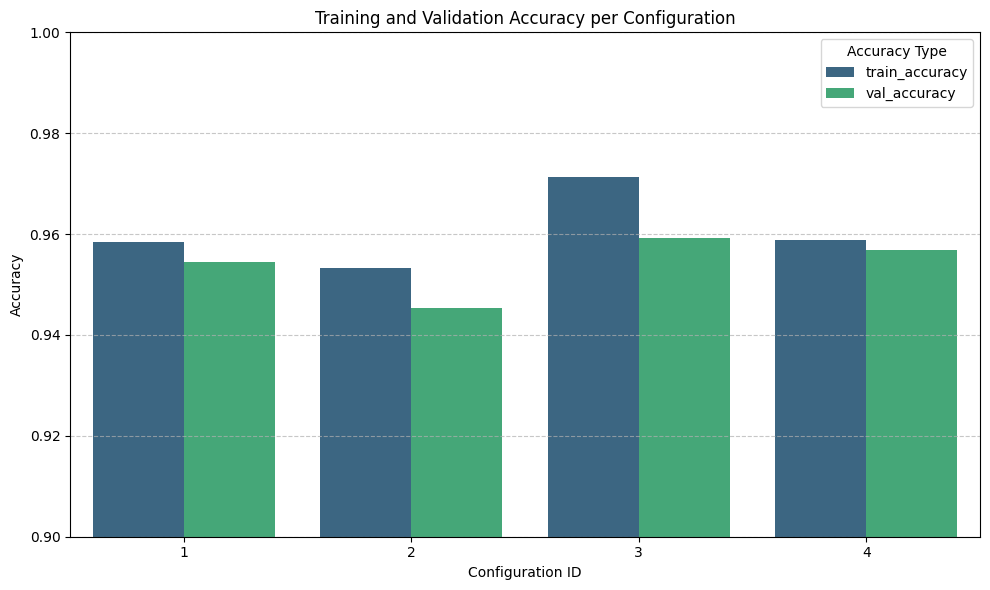

In [6]:
# Add a 'Config_ID' for easier plotting
# Check if df is defined. If not, inform the user and suggest running the previous cell.
import pandas as pd # Ensure pandas is imported for DataFrame operations

if 'df' not in locals() and 'df' not in globals():
    print("Error: DataFrame 'df' is not defined. Please ensure the cell where 'df' is created (cell ajQoi9jgtJRc) has been executed successfully before running this cell.")
else:
    df['Config_ID'] = df.index + 1

    # Prepare data for plotting (melt the DataFrame)
    plot_df = df.melt(id_vars=['Config_ID'], value_vars=['train_accuracy', 'val_accuracy'],
                      var_name='Metric', value_name='Accuracy')

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Config_ID', y='Accuracy', hue='Metric', data=plot_df, palette='viridis')
    plt.title('Training and Validation Accuracy per Configuration')
    plt.xlabel('Configuration ID')
    plt.ylabel('Accuracy')
    plt.ylim(0.9, 1.0) # Set appropriate y-axis limits for accuracy
    plt.xticks(rotation=0)
    plt.legend(title='Accuracy Type')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()